# Exercise 6 - Hyperparameter Optimization

In this exercise, we want to see, how to find the *optimal hyperparameters* for a simple CNN models to classify the MNIST dataset.

## Preparations

### Data Preparation

Load tensorflow 2:

In [ ]:
#Check if colab is running
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:

  %tensorflow_version 2.x

#import TF
import tensorflow as tf
from platform import python_version
print("Tensorflow version", tf.__version__)
print("Python version =",python_version())

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Tensorflow version 2.15.0
Python version = 3.10.12


In [ ]:
# Most of the libraries we will use in this exercise

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools

from sklearn.model_selection import train_test_split, StratifiedKFold
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, InputLayer
from tensorflow.keras.callbacks import ModelCheckpoint, Callback

Let's first load and preprocess the data as we did in exercise 5:

In [ ]:
np.random.seed(1338)  # for reproducibilty!!

# input image dimensions
img_rows, img_cols = 28, 28
# number of classes
nb_classes = 10

#Load the data
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

11490434/11490434 [==============================] - 1s 0us/step


In [ ]:
num_train_samples = len(X_train)
print("Number of training samples:", num_train_samples)
num_test_samples = len(X_test)
print("Number of test samples:", num_test_samples)

Number of training samples: 60000
Number of test samples: 10000


In [ ]:
#Take just 20k example for training for speed reasons
X_train_reduced = X_train[:20000]
Y_train_reduced = Y_train[:20000]

As the scikit learn scalers are not very nice in the case of images and we know (well, you might know at least), that pictures have color values between 0 and 255, we can rescale by dividing by 255. The target vector is converted to categorical.

In [ ]:
print(X_train.min(), X_train.max())

# scale with global maximum
X_train_scaled = X_train_reduced/255
X_test_scaled = X_test/255

# add "filter" dimension (loaded images are [x,y] only, not [x,y,channels])
X_train_ready = X_train_scaled[..., np.newaxis]
X_test_ready = X_test_scaled[..., np.newaxis]

#convert target vector
Y_train_ready = to_categorical(Y_train_reduced, nb_classes)
Y_test_ready = to_categorical(Y_test, nb_classes)

0 255


### Task 1 (recap): Model preparation
Define a convolutional network as start point for our optimization. Design it following these points:
- Use two convolutional layers followed by a pooling layer.
- Use one hidden dense layer.
- Use dropout before and after the hidden dense layer.
- How many output nodes do you need? Add a dense output layer accordingly.
- Which activation function should you use in the output layer?
- Choose a loss function that is suitable for our problem at hand.
- Compile the model and look at the summary. How many parameters do you have?

In [ ]:
## Task

# Start here
model = Sequential([
                    # add layers here
])


In [ ]:
## Solution

model = Sequential([
  Conv2D(32, kernel_size=(2, 2),
          padding='valid', activation='relu',
          input_shape=X_train_ready[0].shape),
  Conv2D(64, kernel_size=(2, 2),
          padding='valid', activation='relu'),
  MaxPooling2D(pool_size=(2, 2)),
  Flatten(),
  Dropout(.5),
  Dense(64, activation='relu'),
  Dropout(.5),
  Dense(10, activation='softmax')
])

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 27, 27, 32)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 64)        8256      
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 64)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 10816)             0         
                                                                 
 dropout (Dropout)           (None, 10816)             0         
                                                                 
 dense (Dense)               (None, 64)                692288    
                                                      

### A first estimate: how accurate can the model predict the digits?
Before we start to look around for better ways to build the network, we just run it as is for now.

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(X_train_ready, Y_train_ready, train_size=.7, test_size=.3)

In [ ]:
fit_results = model.fit(
    x=x_train,
    y=y_train,
    batch_size=128,
    epochs=15,
    validation_data=(x_val, y_val)
)

Epoch 1/15
110/110 [==============================] - 7s 13ms/step - loss: 0.8097 - accuracy: 0.7416 - val_loss: 0.2722 - val_accuracy: 0.9242
Epoch 2/15
110/110 [==============================] - 1s 8ms/step - loss: 0.3772 - accuracy: 0.8876 - val_loss: 0.1701 - val_accuracy: 0.9517
Epoch 3/15
110/110 [==============================] - 1s 8ms/step - loss: 0.2682 - accuracy: 0.9192 - val_loss: 0.1315 - val_accuracy: 0.9608
Epoch 4/15
110/110 [==============================] - 1s 8ms/step - loss: 0.2155 - accuracy: 0.9349 - val_loss: 0.1044 - val_accuracy: 0.9692
Epoch 5/15
110/110 [==============================] - 1s 8ms/step - loss: 0.1860 - accuracy: 0.9446 - val_loss: 0.1091 - val_accuracy: 0.9680
Epoch 6/15
110/110 [==============================] - 1s 8ms/step - loss: 0.1721 - accuracy: 0.9481 - val_loss: 0.0895 - val_accuracy: 0.9723
Epoch 7/15
110/110 [==============================] - 1s 8ms/step - loss: 0.1528 - accuracy: 0.9523 - val_loss: 0.0831 - val_accuracy: 0.9743
Epoch

Training Loss: 0.013991901651024818
Training Accuracy: 0.9962142705917358
Validation Loss: 0.07187502831220627
Validation Accuracy: 0.9788333177566528


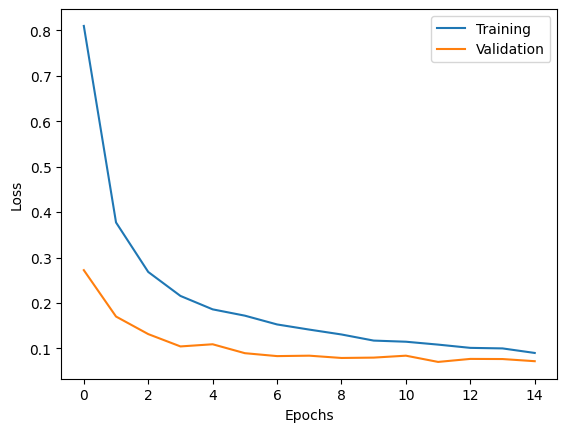

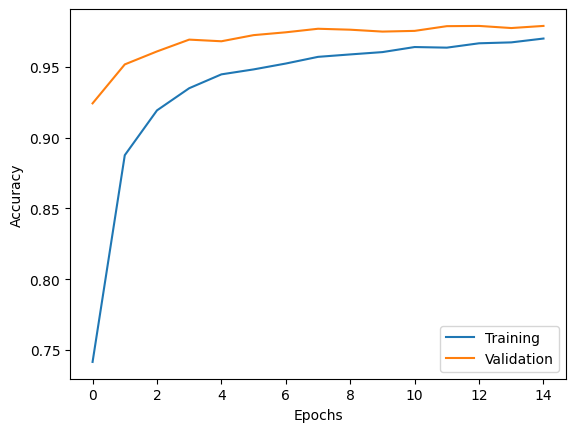

In [ ]:
loss, accuracy = model.evaluate(x_train, y_train, verbose=0)
print('Training Loss:', loss)
print('Training Accuracy:', accuracy)

val_loss, val_accuracy = model.evaluate(x_val, y_val, verbose=0)
print('Validation Loss:', val_loss)
print('Validation Accuracy:', val_accuracy)

plt.plot(fit_results.history['loss'], label='Training')
plt.plot(fit_results.history['val_loss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(fit_results.history['accuracy'], label='Training')
plt.plot(fit_results.history['val_accuracy'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Quick recap question
The accuracies returned by the model in the history object and obtained via evaluate() are very different for the training data but not for the validation data. Why is this?

In [ ]:
print("Training accuracy from history:", fit_results.history['accuracy'][-1])
print("Training accuracy with evaluate():", accuracy)

print("Validation accuracy from history:", fit_results.history['val_accuracy'][-1])
print("Validation accuracy with evaluate():", val_accuracy)

Training accuracy from history: 0.9699285626411438
Training accuracy with evaluate(): 0.9962142705917358
Validation accuracy from history: 0.9788333177566528
Validation accuracy with evaluate(): 0.9788333177566528


For now, this will not be so much of a problem in this exercise as we will be mostly looking at final/ best validation accuracies, not so much at loss curves (for now). If you do not remember a possible approach to solve this discrepancy, look back in exercise 4.

A callback we will definetely need though is the model checkpoint callback. With the model checkpoint callback we can store the best network during training.

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

## Hyperparameter optimizations: Gridsearch
Updating parameters manually and re-running the training takes a long time and keeping track of the progress is difficult. If you want to search for an optimal hyperparameter-configuration, a grid search over a parameter space is more recommendable. The simplest form of grid search is the iteration over a parameter space.

### Loop over a parameter - filter sizes

As a first test, we will search for different configurations of filter sizes for our two convolutional layers. We will choose the following configuration: We set the number of filters for the first convolutional layer and set the filters of the second convolutional layer to be twice as many.

In [ ]:

search_results = []

filters_candidates = [
  # very limited test, you can explore more!
  16, 32, 64
]

for nb_filters in filters_candidates:
  print("Start training for nb_filters=", nb_filters)

  ########################################
  # Use your own model here!!
  ########################################
  model = Sequential([
    Conv2D(
        nb_filters, kernel_size=2, padding='valid',
        activation='relu', input_shape=x_train[0].shape
    ),
    Conv2D(
        int(nb_filters*2), kernel_size=2,
        padding='valid', activation='relu'
    ),
    MaxPooling2D(pool_size=2),
    Dropout(0.5),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(10, activation='softmax')
  ])
  model.compile(
      loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']
  )
  ########################################

  # we choose our best model as the one having the highest validation accuracy
  filepath = f"cnn_paramsearch_filters_{nb_filters}.hdf5"
  checkpoint = ModelCheckpoint(
      filepath, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max'
  )

  fit_results = model.fit(
    x=x_train,
    y=y_train,
    batch_size=128,
    # reduce number of epochs for speed reasons --> should be higher!
    epochs=10,
    validation_data=(x_val, y_val),
    callbacks=[checkpoint],
    verbose=0
  )

  # extract the best validation scores
  best_val_epoch    = np.argmax(fit_results.history['val_accuracy'])
  best_val_acc      = np.max(fit_results.history['val_accuracy'])
  best_val_acc_loss = fit_results.history['val_loss'][best_val_epoch]

  # get correct training accuracy
  best_model = load_model(filepath)
  best_val_acc_train_loss, best_val_acc_train_acc = best_model.evaluate(x_train, y_train)

  # store results
  search_results.append({
      'nb_filters': nb_filters,
      'best_val_acc_train_acc': best_val_acc_train_acc,
      'best_val_acc': best_val_acc,
      'best_val_acc_train_loss': best_val_acc_train_loss,
      'best_val_acc_loss': best_val_acc_loss,
      'best_val_epoch': best_val_epoch
  })

Start training for nb_filters= 16


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


438/438 [==============================] - 1s 3ms/step - loss: 0.0227 - accuracy: 0.9947
Start training for nb_filters= 32
438/438 [==============================] - 1s 3ms/step - loss: 0.0104 - accuracy: 0.9974
Start training for nb_filters= 64
438/438 [==============================] - 2s 4ms/step - loss: 0.0063 - accuracy: 0.9987


We will inspect the results using pandas DataFrames:

In [ ]:
resultsDF = pd.DataFrame(search_results)

# sort values
resultsDF.sort_values('best_val_acc', ascending=False)

,nb_filters,best_val_acc_train_acc,best_val_acc,best_val_acc_train_loss,best_val_acc_loss,best_val_epoch
2,64,0.998714,0.982000,0.006276,0.065181,8
1,32,0.997357,0.981667,0.010410,0.064897,9
0,16,0.994714,0.978167,0.022706,0.072397,9


### Grid search over a more complex parameter space
The simplest way to extend the example above to a grid containing more parameters is the following one:

In [ ]:

search_results = []

filters_candidates = [
  16, 32, 64
]
dense_candidates = [
  32, 64, 128
]
dropout_candidates = [
  .3, .4, .5
]

for nb_filters in filters_candidates:
  for nb_dense in dense_candidates:
    for dropout in dropout_candidates:

      print(f"Start training for (filters={nb_filters} - dense={nb_dense} - dropout={dropout})")

      ########################################
      # Use your own model here!!
      ########################################
      model = Sequential([
        Conv2D(
            nb_filters, kernel_size=2, padding='valid',
            activation='relu', input_shape=x_train[0].shape
        ),
        Conv2D(
            int(nb_filters*2), kernel_size=2,
            padding='valid', activation='relu'
        ),
        MaxPooling2D(pool_size=2),
        Dropout(dropout),
        Flatten(),
        Dense(nb_dense, activation='relu'),
        Dropout(dropout),
        Dense(10, activation='softmax')
      ])
      model.compile(
          loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']
      )
      ########################################

      # we choose our best model as the one having the highest validation accuracy
      filepath = f"cnn_paramsearch_filters_f={nb_filters}_dn={nb_dense}_do={dropout}.hdf5"
      checkpoint = ModelCheckpoint(
          filepath, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max'
      )

      fit_results = model.fit(
        x=x_train,
        y=y_train,
        batch_size=128,
        # reduce number of epochs for speed reasons --> should be higher!
        epochs=10,
        validation_data=(x_val, y_val),
        callbacks=[checkpoint],
        verbose=0
      )

      # extract the best validation scores
      best_val_epoch    = np.argmax(fit_results.history['val_accuracy'])
      best_val_acc      = np.max(fit_results.history['val_accuracy'])
      best_val_acc_loss = fit_results.history['val_loss'][best_val_epoch]

      # get correct training accuracy
      best_model = load_model(filepath)
      best_val_acc_train_loss, best_val_acc_train_acc = best_model.evaluate(x_train, y_train)

      # store results
      search_results.append({
          'nb_filters': nb_filters,
          'nb_dense': nb_dense,
          'dropout': dropout,
          'best_val_acc_train_acc': best_val_acc_train_acc,
          'best_val_acc': best_val_acc,
          'best_val_acc_train_loss': best_val_acc_train_loss,
          'best_val_acc_loss': best_val_acc_loss,
          'best_val_epoch': best_val_epoch
      })

Start training for (filters=16 - dense=32 - dropout=0.3)


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


438/438 [==============================] - 1s 3ms/step - loss: 0.0514 - accuracy: 0.9856
Start training for (filters=16 - dense=32 - dropout=0.4)
438/438 [==============================] - 2s 4ms/step - loss: 0.0593 - accuracy: 0.9824
Start training for (filters=16 - dense=32 - dropout=0.5)
438/438 [==============================] - 1s 3ms/step - loss: 0.0677 - accuracy: 0.9807
Start training for (filters=16 - dense=64 - dropout=0.3)
438/438 [==============================] - 1s 3ms/step - loss: 0.0185 - accuracy: 0.9954
Start training for (filters=16 - dense=64 - dropout=0.4)
438/438 [==============================] - 1s 3ms/step - loss: 0.0267 - accuracy: 0.9924
Start training for (filters=16 - dense=64 - dropout=0.5)
438/438 [==============================] - 1s 3ms/step - loss: 0.0394 - accuracy: 0.9884
Start training for (filters=16 - dense=128 - dropout=0.3)
438/438 [==============================] - 1s 3ms/step - loss: 0.0165 - accuracy: 0.9970
Start training for (filters=16 - d

In [ ]:
resultsDF = pd.DataFrame(search_results)

# sort values
resultsDF.sort_values('best_val_acc', ascending=False)

,nb_filters,nb_dense,dropout,best_val_acc_train_acc,best_val_acc,best_val_acc_train_loss,best_val_acc_loss,best_val_epoch
26,64,128,0.5,0.998929,0.984333,0.005553,0.056911,9
15,32,128,0.3,0.999000,0.984167,0.005589,0.055703,7
25,64,128,0.4,0.999357,0.983500,0.004272,0.057288,8
16,32,128,0.4,0.997714,0.983167,0.008145,0.065463,9
21,64,64,0.3,0.997357,0.982833,0.012169,0.057261,5
17,32,128,0.5,0.996714,0.982500,0.010949,0.057244,9
22,64,64,0.4,0.999000,0.982333,0.006657,0.064943,9
3,16,64,0.3,0.995429,0.982167,0.018532,0.064059,8
6,16,128,0.3,0.997000,0.982000,0.016529,0.062422,6
24,64,128,0.3,0.997714,0.981833,0.011177,0.062109,4


Let's include another column that denotes the difference between train and val score:

In [ ]:
resultsDF['delta_acc'] = (resultsDF['best_val_acc_train_acc']-resultsDF['best_val_acc'])/resultsDF['best_val_acc']

A seaborn pairplot can be useful to inspect dependencies of numerical parameters on the validation loss:

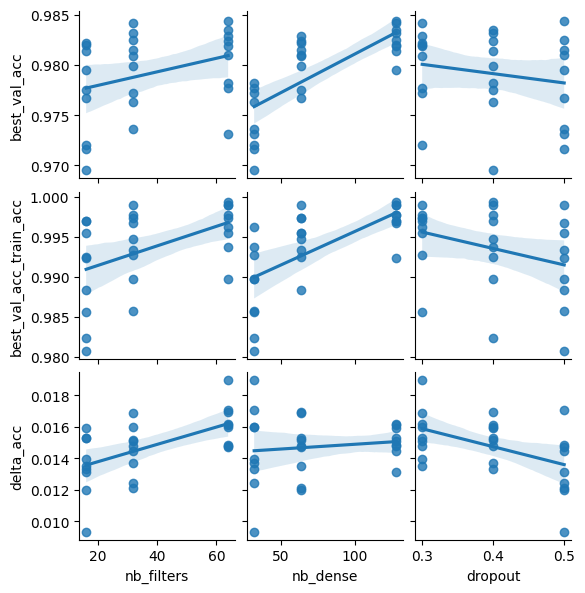

In [ ]:
import seaborn as sns
sns.pairplot(resultsDF, x_vars=['nb_filters', 'nb_dense', 'dropout', ], y_vars=['best_val_acc', 'best_val_acc_train_acc', 'delta_acc'], kind='reg',  height=2)

### Task 2: Gridsearch interpretation
- Which parameter combination shows the best validation loss?
- How do validation and train loss compare to each other?
- What might be a problem choosing the hyperparameters based on the validation loss?
- How might you further improve the robustness/ generalization performance?



#### Task 2: Solution

1. When running the code, the best validation loss (`0.055108`) was achieved combination with `nb_filters=64`, `nb_dense=128`, and a dropout rate of `0.4`. This does not coincide with the best validation accuracy but is in fact very close.
2. The validation loss is `lv = 0.055108`, the training loss at this epoch is `lt = 0.005224` which is substantially smaller.
3. The validation loss is not necessarily the best measure for our model performance but rather a function that is very suitable for the minimization problem. It is always important to think carefully about the metric that should be maximized/ minimized. In the case of digit recognition for example, the accuracy would be a more suitable performance measure than the categorical crossentropy (loss).
4. The range of hyperparameters does not seem to cover a good range in this example. You cannot be confident you really find an optimal set of parameters if they occur on the boundary of search grid (in this case the hightest accuracy was found with the maximum number of dense nodes and the minimal loss was found for the maximum number of filters). Also, hyperparameter searches are more reproducible with a fixed seed. The given optimization is prone to small statistical fluctuations due to random initialization. When the performance of different models do not depent on a given parameter or is the same for different parameter combinations, it can be helpful to choose the simplest best performing model (Occam's razor)

In [ ]:
# Part of solution of task 2:
resultsDF.sort_values('best_val_acc_loss').head()

,nb_filters,nb_dense,dropout,best_val_acc_train_acc,best_val_acc,best_val_acc_train_loss,best_val_acc_loss,best_val_epoch,delta_acc
15,32,128,0.3,0.999000,0.984167,0.005589,0.055703,7,0.015072
26,64,128,0.5,0.998929,0.984333,0.005553,0.056911,9,0.014828
17,32,128,0.5,0.996714,0.982500,0.010949,0.057244,9,0.014467
21,64,64,0.3,0.997357,0.982833,0.012169,0.057261,5,0.014777
25,64,128,0.4,0.999357,0.983500,0.004272,0.057288,8,0.016123


Testing different parameters in the way you just did is rather exhausting. We want to adjust this by using dictionaries to pass a parameter space in a more convenient way. Using itertools.product, we can produce all combinations from a dictionary containing lists of candidates:

In [ ]:
# an even more reduced parameter space, but this time with structural changes
param_space = {
    'num_conv_layers': [1,2,3],
    'max_filters': [32, 64],
    'dropout': [ .4, .5],
    'dense_nodes': [32, 64]
}

# this handy tools generates all combinations of values from the grid above
import itertools
value_combis = itertools.product(*[v for v in param_space.values()])

param_combis = []
for combi in value_combis:
  param_combis.append({key: value for key, value in zip(param_space.keys(), combi)})

# List comprehension short form:
# param_combis = [{key:value for key, value in zip(param_space.keys(), combi)} for combi in value_combis]

print(f"We have a total of {len(param_combis)} combinations:")
print(param_combis)

We have a total of 24 combinations:
[{'num_conv_layers': 1, 'max_filters': 32, 'dropout': 0.4, 'dense_nodes': 32}, {'num_conv_layers': 1, 'max_filters': 32, 'dropout': 0.4, 'dense_nodes': 64}, {'num_conv_layers': 1, 'max_filters': 32, 'dropout': 0.5, 'dense_nodes': 32}, {'num_conv_layers': 1, 'max_filters': 32, 'dropout': 0.5, 'dense_nodes': 64}, {'num_conv_layers': 1, 'max_filters': 64, 'dropout': 0.4, 'dense_nodes': 32}, {'num_conv_layers': 1, 'max_filters': 64, 'dropout': 0.4, 'dense_nodes': 64}, {'num_conv_layers': 1, 'max_filters': 64, 'dropout': 0.5, 'dense_nodes': 32}, {'num_conv_layers': 1, 'max_filters': 64, 'dropout': 0.5, 'dense_nodes': 64}, {'num_conv_layers': 2, 'max_filters': 32, 'dropout': 0.4, 'dense_nodes': 32}, {'num_conv_layers': 2, 'max_filters': 32, 'dropout': 0.4, 'dense_nodes': 64}, {'num_conv_layers': 2, 'max_filters': 32, 'dropout': 0.5, 'dense_nodes': 32}, {'num_conv_layers': 2, 'max_filters': 32, 'dropout': 0.5, 'dense_nodes': 64}, {'num_conv_layers': 2, 'max

With this, we can write the search a bit more condensed:

In [ ]:
search_results = []

for idx, params in enumerate(param_combis):

    print(f"Start run {idx+1}/{len(param_combis)}: Parameters: {params}")


    model = Sequential()
    model.add(InputLayer(x_train[0].shape))

    filters = params['max_filters']
    for layer in range(params['num_conv_layers']):
      model.add(Conv2D(
          filters, kernel_size=2, padding='valid',
          activation='relu'
      ))
      filters /= 2

    for layer in [
      MaxPooling2D(pool_size=2),
      Dropout(params['dropout']),
      Flatten(),
      Dense(params['dense_nodes'], activation='relu'),
      Dropout(params['dropout']),
      Dense(10, activation='softmax')
    ]:
      model.add(layer)

    model.compile(
        loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']
    )
    ########################################

    # we choose our best model as the one having the highest validation accuracy
    string_config = ""
    for key, value in params.items():
      string_config += key + "=" + str(value)
    filepath = f"cnn_paramsearch_filters_{string_config}.hdf5"
    checkpoint = ModelCheckpoint(
        filepath, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max'
    )

    fit_results = model.fit(
      x=x_train,
      y=y_train,
      batch_size=128,
      # reduce number of epochs for speed reasons --> should be higher!
      epochs=5,
      validation_data=(x_val, y_val),
      callbacks=[checkpoint],
      verbose=0
    )

    # extract the best validation scores
    best_val_epoch    = np.argmax(fit_results.history['val_accuracy'])
    best_val_acc      = np.max(fit_results.history['val_accuracy'])
    best_val_acc_loss = fit_results.history['val_loss'][best_val_epoch]

    # get correct training accuracy
    best_model = load_model(filepath)
    best_val_acc_train_loss, best_val_acc_train_acc = best_model.evaluate(x_train, y_train)

    # store results
    search_results.append({
        **params,
        'best_val_acc_train_acc': best_val_acc_train_acc,
        'best_val_acc': best_val_acc,
        'best_val_acc_train_loss': best_val_acc_train_loss,
        'best_val_acc_loss': best_val_acc_loss,
        'best_val_epoch': best_val_epoch
    })

Start run 1/24: Parameters: {'num_conv_layers': 1, 'max_filters': 32, 'dropout': 0.4, 'dense_nodes': 32}


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


438/438 [==============================] - 1s 2ms/step - loss: 0.1849 - accuracy: 0.9495
Start run 2/24: Parameters: {'num_conv_layers': 1, 'max_filters': 32, 'dropout': 0.4, 'dense_nodes': 64}
438/438 [==============================] - 2s 4ms/step - loss: 0.1239 - accuracy: 0.9650
Start run 3/24: Parameters: {'num_conv_layers': 1, 'max_filters': 32, 'dropout': 0.5, 'dense_nodes': 32}
438/438 [==============================] - 1s 3ms/step - loss: 0.1818 - accuracy: 0.9520
Start run 4/24: Parameters: {'num_conv_layers': 1, 'max_filters': 32, 'dropout': 0.5, 'dense_nodes': 64}
438/438 [==============================] - 2s 3ms/step - loss: 0.1465 - accuracy: 0.9613
Start run 5/24: Parameters: {'num_conv_layers': 1, 'max_filters': 64, 'dropout': 0.4, 'dense_nodes': 32}
438/438 [==============================] - 1s 2ms/step - loss: 0.1604 - accuracy: 0.9561
Start run 6/24: Parameters: {'num_conv_layers': 1, 'max_filters': 64, 'dropout': 0.4, 'dense_nodes': 64}
438/438 [=====================

In [ ]:
resultsDF = pd.DataFrame(search_results)

# sort values
resultsDF.sort_values('best_val_acc', ascending=False)

,num_conv_layers,max_filters,dropout,dense_nodes,best_val_acc_train_acc,best_val_acc,best_val_acc_train_loss,best_val_acc_loss,best_val_epoch
13,2,64,0.4,64,0.984000,0.974667,0.053537,0.084034,4
21,3,64,0.4,64,0.982500,0.973500,0.055379,0.082241,4
9,2,32,0.4,64,0.978071,0.970500,0.076465,0.100815,4
15,2,64,0.5,64,0.974714,0.969667,0.083408,0.106055,3
23,3,64,0.5,64,0.972143,0.966167,0.097113,0.113043,4
19,3,32,0.5,64,0.969071,0.964167,0.109380,0.124025,4
11,2,32,0.5,64,0.967857,0.963333,0.111343,0.128404,4
20,3,64,0.4,32,0.969357,0.963167,0.100533,0.123851,4
5,1,64,0.4,64,0.974143,0.960667,0.092106,0.132760,4
17,3,32,0.4,64,0.967357,0.960500,0.113945,0.134221,4


### Task 3: Include loss curves
You can also return the loss curves from your search to inspect them and search for overtraining. Include it in the search above and compare the loss curves for training and validation for the best three combinations.

Bonus: We use dropout, therefore it is more correct if we use a callback function to evaluate the training loss and accuracy after the end of every epoch.


In [ ]:
# Space for solutions

# an even more reduced parameter space, but this time with structural changes
param_space = {
    'num_conv_layers': [1,2,3],
    'max_filters': [32, 64],
    'dropout': [.5],
    'dense_nodes': [64]
}

# this handy tools generates all combinations of values from the grid above
import itertools
value_combis = itertools.product(*[v for v in param_space.values()])

param_combis = []
for combi in value_combis:
  param_combis.append({key: value for key, value in zip(param_space.keys(), combi)})


search_results = []


### Bonus: training data evaluation callback
from tensorflow.keras.callbacks import Callback

class HistoryEpoch(Callback):
    def __init__(self, data):
        self.data = data

    def on_epoch_end(self, epoch, logs={}):
        x, y = self.data
        l, a = self.model.evaluate(x, y, verbose=0)
        logs['train_loss'] = l
        logs['train_accuracy'] = a

for idx, params in enumerate(param_combis):

    print(f"Start run {idx+1}/{len(param_combis)}: Parameters: {params}")


    model = Sequential()
    model.add(InputLayer(x_train[0].shape))

    filters = params['max_filters']
    for layer in range(params['num_conv_layers']):
      model.add(Conv2D(
          filters, kernel_size=2, padding='valid',
          activation='relu'
      ))
      filters /= 2

    for layer in [
      MaxPooling2D(pool_size=2),
      Dropout(params['dropout']),
      Flatten(),
      Dense(params['dense_nodes'], activation='relu'),
      Dropout(params['dropout']),
      Dense(10, activation='softmax')
    ]:
      model.add(layer)

    model.compile(
        loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']
    )
    ########################################

    # we choose our best model as the one having the highest validation accuracy
    string_config = ""
    for key, value in params.items():
      string_config += key + "=" + str(value)
    filepath = f"cnn_paramsearch_filters_{string_config}.hdf5"
    checkpoint = ModelCheckpoint(
        filepath, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max'
    )

    fit_results = model.fit(
      x=x_train,
      y=y_train,
      batch_size=128,
      # reduce number of epochs for speed reasons --> should be higher!
      epochs=20,
      validation_data=(x_val, y_val),
      callbacks=[checkpoint, HistoryEpoch((x_train, y_train))],
      verbose=0
    )

    # extract the best validation scores
    best_val_epoch    = np.argmax(fit_results.history['val_accuracy'])
    best_val_acc      = np.max(fit_results.history['val_accuracy'])
    best_val_acc_loss = fit_results.history['val_loss'][best_val_epoch]

    # get correct training accuracy
    # this time differently!
    best_val_acc_train_loss = fit_results.history['train_loss'][best_val_epoch]
    best_val_acc_train_acc = fit_results.history['train_accuracy'][best_val_epoch]

    # store results

    ###
    ### We simply return the full history object that contains the loss and metric curves
    ###

    search_results.append({
        **params,
        'best_val_acc_train_acc': best_val_acc_train_acc,
        'best_val_acc': best_val_acc,
        'best_val_acc_train_loss': best_val_acc_train_loss,
        'best_val_acc_loss': best_val_acc_loss,
        'best_val_epoch': best_val_epoch,
        'history': fit_results.history
    })

Start run 1/6: Parameters: {'num_conv_layers': 1, 'max_filters': 32, 'dropout': 0.5, 'dense_nodes': 64}


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Start run 2/6: Parameters: {'num_conv_layers': 1, 'max_filters': 64, 'dropout': 0.5, 'dense_nodes': 64}
Start run 3/6: Parameters: {'num_conv_layers': 2, 'max_filters': 32, 'dropout': 0.5, 'dense_nodes': 64}
Start run 4/6: Parameters: {'num_conv_layers': 2, 'max_filters': 64, 'dropout': 0.5, 'dense_nodes': 64}
Start run 5/6: Parameters: {'num_conv_layers': 3, 'max_filters': 32, 'dropout': 0.5, 'dense_nodes': 64}
Start run 6/6: Parameters: {'num_conv_layers': 3, 'max_filters': 64, 'dropout': 0.5, 'dense_nodes': 64}


In [ ]:
# Part of solution for task 3

# Let's inspect the history object:
search_results[0]['history'].keys()

# the entry "train_loss" was added by us in the callback, normally it is just 'loss'

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'train_loss', 'train_accuracy'])

In [ ]:
# which combinations perform best?
df = pd.DataFrame(search_results).sort_values('best_val_acc', ascending=False)
display(df)

top_3_indices = df.index.values[:3]

,num_conv_layers,max_filters,dropout,dense_nodes,best_val_acc_train_acc,best_val_acc,best_val_acc_train_loss,best_val_acc_loss,best_val_epoch,history
5,3,64,0.5,64,0.995143,0.985667,0.020207,0.054907,18,"{'loss': [0.9658993482589722, 0.41441828012466..."
3,2,64,0.5,64,0.997429,0.982167,0.011951,0.060244,19,"{'loss': [0.84870445728302, 0.3593761920928955..."
2,2,32,0.5,64,0.991786,0.980000,0.028685,0.068936,19,"{'loss': [1.0392075777053833, 0.48553389310836..."
4,3,32,0.5,64,0.988214,0.979167,0.040960,0.071258,19,"{'loss': [1.2083516120910645, 0.65026205778121..."
1,1,64,0.5,64,0.992929,0.973833,0.025938,0.085910,19,"{'loss': [0.8865368962287903, 0.47416508197784..."
0,1,32,0.5,64,0.987143,0.971500,0.046751,0.098350,17,"{'loss': [0.9604501128196716, 0.48774418234825..."


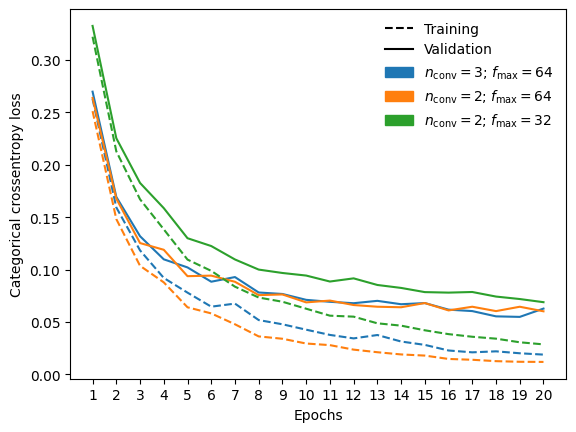

In [ ]:
# Part of solution for task 3

# empty plots, just to get the legend entries
plt.plot([],[],'k--', label='Training')
plt.plot([],[],'k-', label='Validation')

# let's have a look at loss curves of the three best performing models
for idx, (row_index, row_series) in enumerate(df.head(3).iterrows()):
  x = np.arange(1, len(row_series['history']['train_loss'])+1)
  parameter_combination_string = f"$n_\\mathrm{{conv}}=${row_series['num_conv_layers']}; $f_\\mathrm{{max}}=${row_series['max_filters']}"
  plt.plot(x, row_series['history']['train_loss'], '--', color=f'C{idx}')
  plt.plot(x, row_series['history']['val_loss'], '-', color=f'C{idx}')

  # and again empty, just for the legend entry
  plt.fill_between([],[],[],color=f'C{idx}', label=parameter_combination_string)


plt.xlabel('Epochs')
# limit ticks to integers using the length of the last results loss curve
plt.xticks(x)
plt.ylabel('Categorical crossentropy loss')

# people should use those frames less frequently I think
plt.legend(frameon=False)



## Cross-validation - the grid searches best companion

The grid search we have now up and running is a really nice tool to test different hyperparameter combinations and inspect how the different parameters affect the training outcome.

Using the validation scores for evaluating the generalization performance of our model we have improved compared to inspecting the training score. But especially in the case of rather small data sets, this can introduce another form of bias! If we choose a model based on the validation score, this might mean that is simply works very well for this particular validation data set out of coincidence and no real generalization was achieved. This is quite a difficult one to catch. To investigate this, one would have to test the performance on a variety of validation data sets and rather use their average score than just one result from one test. And this is, what cross-validation is about.

### Basics of cross validation
For a cross validation, the *training data* is not only divided into one training and one validation set, but different splits are performed. For a *k-fold cross validation*, the data is split into *k* parts, then the model with a certain hyperparameter configuration is trained on *k-1* of the parts and then evaluated on the remaining part. The overall score can then be computed e. g. by using the average validation score.

<img src="https://cdn-images-1.medium.com/max/800/1*HITaUenDsDuzjAWO0zZyxg.png" height=300>

(image: https://alexforrest.github.io/you-might-be-leaking-data-even-if-you-cross-validate.html)

By this, the resulting score is more likely to reflect the performance we would see on a truely unknown data set like the test data set. As the title of the source of the image suggests, there are more sophisticated ways of improving the generalization performance evaluation for our model, but cross validation certainly is a good start!

scikit-learn provides a simple api for performing k-fold data splits similar to the train-test-split method.

In [ ]:
# yes, we did already import this earlier
from sklearn.model_selection import StratifiedKFold

The *StratifiedKFold* preserves the relative occurences of members of different classes within the different splits. For this classification problem, we will therefore rather use this than the normal KFold.

We will use cross-validation with k=3 (speed) and compute an `average precision` as a score value to find the best parameter set. The best metric for optimization depends on your problem and finding a good one for your application is a central trask of each machine learning investigation. We will modify the test function so that we will not use the TensorBoard for now:

In [ ]:
# an even more reduced parameter space, but this time with structural changes
param_space = {
    'num_conv_layers': [2,3,4],
    'max_filters': [32, 64],
    'dropout': [.5],
    'dense_nodes': [64]
}

value_combis = itertools.product(*[v for v in param_space.values()])

# List comprehension short form:
param_combis = [{key:value for key, value in zip(param_space.keys(), combi)} for combi in value_combis]

print(f"We have a total of {len(param_combis)} combinations:")
print(param_combis)

We have a total of 6 combinations:
[{'num_conv_layers': 2, 'max_filters': 32, 'dropout': 0.5, 'dense_nodes': 64}, {'num_conv_layers': 2, 'max_filters': 64, 'dropout': 0.5, 'dense_nodes': 64}, {'num_conv_layers': 3, 'max_filters': 32, 'dropout': 0.5, 'dense_nodes': 64}, {'num_conv_layers': 3, 'max_filters': 64, 'dropout': 0.5, 'dense_nodes': 64}, {'num_conv_layers': 4, 'max_filters': 32, 'dropout': 0.5, 'dense_nodes': 64}, {'num_conv_layers': 4, 'max_filters': 64, 'dropout': 0.5, 'dense_nodes': 64}]


In [ ]:
def build_model_from_params(params):
  model = Sequential()
  model.add(InputLayer(x_train[0].shape))

  filters = params['max_filters']
  for layer in range(params['num_conv_layers']):
    model.add(Conv2D(
        filters, kernel_size=2, padding='valid',
        activation='relu'
    ))
    filters /= 2

  for layer in [
    MaxPooling2D(pool_size=2),
    Dropout(params['dropout']),
    Flatten(),
    Dense(params['dense_nodes'], activation='relu'),
    Dropout(params['dropout']),
    Dense(10, activation='softmax')
  ]:
    model.add(layer)

  model.compile(
      loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']
  )
  return model

search_results = []

k_folds = 3

for idx, params in enumerate(param_combis):

    print(f"Start run {idx+1}/{len(param_combis)}: Parameters: {params}")

    k = 3
    kf = StratifiedKFold(n_splits=k)

    # we create some lists to append to during the validation folds
    best_val_accs             = []
    best_val_acc_losses       = []
    best_val_acc_train_accs   = []
    best_val_acc_train_losses = []

    y_labels = np.argmax(Y_train_ready, axis=1)
    for k_index, (train_idx, val_idx) in enumerate(kf.split(X_train_ready, y_labels)):
      x_cv_train, x_cv_val = X_train_ready[train_idx], X_train_ready[val_idx]
      y_cv_train, y_cv_val = Y_train_ready[train_idx], Y_train_ready[val_idx]

      filepath = f"cnn_paramsearch_filters_fold={k_index}_"
      for key, value in params.items():
        filepath += key + "=" + str(value) + "_"

      filepath += '.hdf5'
      checkpoint = ModelCheckpoint(
          filepath, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max'
      )

      this_model = build_model_from_params(params)

      fit_results = this_model.fit(
        x=x_cv_train,
        y=y_cv_train,
        batch_size=128,
        # reduce number of epochs for speed reasons --> should be higher!
        epochs=5,
        validation_data=(x_cv_val, y_cv_val),
        callbacks=[checkpoint],
        verbose=0
      )

      # extract the best validation scores
      best_val_epoch = np.argmax(fit_results.history['val_accuracy'])
      best_val_accs.append(np.max(fit_results.history['val_accuracy']))
      best_val_acc_losses.append(fit_results.history['val_loss'][best_val_epoch])

      # get correct training accuracy
      best_model = load_model(filepath)
      best_val_acc_train_loss, best_val_acc_train_acc = best_model.evaluate(x_train, y_train)
      best_val_acc_train_losses.append(best_val_acc_train_loss)
      best_val_acc_train_accs.append(best_val_acc_train_acc)

    # store results
    search_results.append({
        **params,
        'best_val_acc': np.mean(best_val_accs),
        'best_val_acc_sem': np.std(best_val_accs)/np.sqrt(k),
        'best_val_acc_train_acc': np.mean(best_val_acc_train_accs),
        'best_val_acc_train_acc_sem': np.std(best_val_acc_train_accs)/np.sqrt(k),
        'best_val_acc_loss': np.mean(best_val_acc_losses),
        'best_val_acc_loss_sem': np.std(best_val_acc_losses)/np.sqrt(k),
        'best_val_acc_train_loss': np.mean(best_val_acc_train_losses),
        'best_val_acc_train_loss_sem': np.std(best_val_acc_train_losses)/np.sqrt(k),
    })

Start run 1/6: Parameters: {'num_conv_layers': 2, 'max_filters': 32, 'dropout': 0.5, 'dense_nodes': 64}


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


438/438 [==============================] - 1s 2ms/step - loss: 0.1244 - accuracy: 0.9649
Start run 2/6: Parameters: {'num_conv_layers': 2, 'max_filters': 64, 'dropout': 0.5, 'dense_nodes': 64}


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


438/438 [==============================] - 1s 2ms/step - loss: 0.1086 - accuracy: 0.9676
Start run 3/6: Parameters: {'num_conv_layers': 3, 'max_filters': 32, 'dropout': 0.5, 'dense_nodes': 64}


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


438/438 [==============================] - 1s 3ms/step - loss: 0.1488 - accuracy: 0.9580
Start run 4/6: Parameters: {'num_conv_layers': 3, 'max_filters': 64, 'dropout': 0.5, 'dense_nodes': 64}


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


438/438 [==============================] - 2s 4ms/step - loss: 0.0924 - accuracy: 0.9725
Start run 5/6: Parameters: {'num_conv_layers': 4, 'max_filters': 32, 'dropout': 0.5, 'dense_nodes': 64}


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


438/438 [==============================] - 1s 3ms/step - loss: 0.1692 - accuracy: 0.9539
Start run 6/6: Parameters: {'num_conv_layers': 4, 'max_filters': 64, 'dropout': 0.5, 'dense_nodes': 64}


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


438/438 [==============================] - 1s 3ms/step - loss: 0.1366 - accuracy: 0.9596


In [ ]:
resultsDF = pd.DataFrame(search_results)

# sort values
resultsDF.sort_values('best_val_acc', ascending=False)

,num_conv_layers,max_filters,dropout,dense_nodes,best_val_acc,best_val_acc_sem,best_val_acc_train_acc,best_val_acc_train_acc_sem,best_val_acc_loss,best_val_acc_loss_sem,best_val_acc_train_loss,best_val_acc_train_loss_sem
3,3,64,0.5,64,0.96415,0.001720,0.969833,0.001462,0.120999,0.005365,0.102705,0.005203
1,2,64,0.5,64,0.96280,0.002167,0.970214,0.001367,0.130748,0.007328,0.102650,0.003595
5,4,64,0.5,64,0.95995,0.002260,0.964571,0.002175,0.137613,0.006696,0.121801,0.006327
0,2,32,0.5,64,0.95635,0.004004,0.963643,0.002120,0.147579,0.012065,0.126953,0.006173
2,3,32,0.5,64,0.95325,0.005063,0.958571,0.003140,0.161977,0.014946,0.143700,0.010493
4,4,32,0.5,64,0.94695,0.004292,0.950476,0.001724,0.191719,0.010813,0.177354,0.003437


You already know one way to inspect a 2D search:

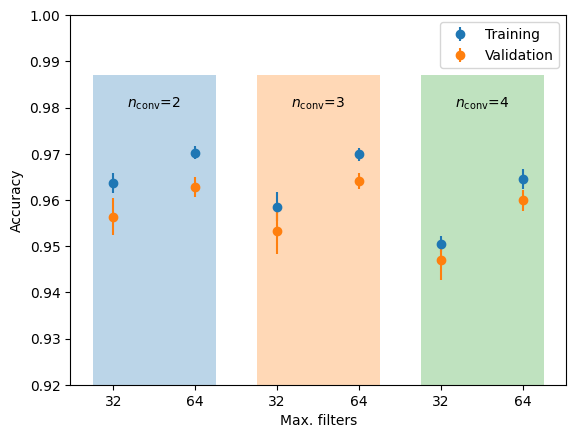

In [ ]:
offset = 0

# you will very likely have to tune this!!
ylims     = (0.92, 1)
fill_lims = (0, 0.987)
text_vertical_loc = 0.98

for num_layers, sub_df in resultsDF.groupby('num_conv_layers'):
  sub_df_entries = len(sub_df)

  x = np.arange(sub_df_entries) + offset

  errb1 = plt.errorbar(x, sub_df['best_val_acc_train_acc'], yerr=sub_df['best_val_acc_train_acc_sem'], fmt='o', color='C0', label='Training')
  errb2 = plt.errorbar(x, sub_df['best_val_acc'], yerr=sub_df['best_val_acc_sem'], fmt='o', color='C1', label='Validation')

  plt.fill_betweenx(fill_lims, x[0]-0.25, x[-1]+0.25, alpha=.3)
  plt.text((x[0]+x[-1])/2,text_vertical_loc , "$n_\\mathrm{conv}$="+str(num_layers), horizontalalignment='center')
  offset += sub_df_entries

plt.xlabel('Max. filters')

# max_filters is a list, a list times a number (number of conv layers) leads to the list being repeated!
xlabels = param_space['max_filters']*len(param_space['num_conv_layers'])
plt.xticks(ticks=np.arange(len(xlabels)), labels=xlabels)

plt.ylabel('Accuracy')
plt.ylim(ylims)
plt.legend([errb1, errb2], ['Training', 'Validation'], loc='best')

## Task 4: Perform a sequentiell grid search to optimze the following hyperparameter. Save the best model for each of the sequentiell steps into a hdf5 file.

You have heard a lot about grid search and cross validation by now. Time for some final hands on!

You can choose whether you want to use a cross validation or a normal grid search. What are point in favor and against?

* Set the dropout rate to `0` for the first steps.
* Find the best convolution + dense structure: Change the width and the depth and try at least 4 different structures
* Find the best activation function for the dense network and the convolutional layers `'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear'`
* Find the best learning rate within [1e-4, 1e-2] (watch out, log scale!) and batch size within [and batch sizes in the range `[32, 2048]`
* Find the best dropout rate: Change dropout between 0 and 0.5


In [ ]:
# Solution for task 4

# We use a grid search without cross validation because the data set it quite large
# Therefore, we have a sufficient amount of validation data that we can split from the
# training data

# 1. Find the best convolution structure:
param_space = {
    'num_conv_layers': [1,2,3,4],
    'max_filters': [16],
    'dropout': [0],
    'dense_nodes': [32]
}

value_combis = itertools.product(*[v for v in param_space.values()])

# List comprehension short form:
param_combis = [{key:value for key, value in zip(param_space.keys(), combi)} for combi in value_combis]

print(f"We have a total of {len(param_combis)} combinations:")
print(param_combis)

class HistoryEpoch(Callback):
    def __init__(self, data):
        self.data = data

    def on_epoch_end(self, epoch, logs={}):
        x, y = self.data
        l, a = self.model.evaluate(x, y, verbose=0)
        logs['train_loss'] = l
        logs['train_accuracy'] = a

search_results = []

# reuse from before:
for idx, params in enumerate(param_combis):

    print(f"Start run {idx+1}/{len(param_combis)}: Parameters: {params}")

    model = Sequential()
    model.add(InputLayer(x_train[0].shape))

    filters = params['max_filters']
    for layer in range(params['num_conv_layers']):
      model.add(Conv2D(
          filters, kernel_size=2, padding='valid',
          activation='relu'
      ))
      filters /= 2

    for layer in [
      MaxPooling2D(pool_size=2),
      Dropout(params['dropout']),
      Flatten(),
      Dense(params['dense_nodes'], activation='relu'),
      Dropout(params['dropout']),
      Dense(10, activation='softmax')
    ]:
      model.add(layer)

    model.compile(
        loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']
    )
    ########################################

    # we choose our best model as the one having the highest validation accuracy
    string_config = ""
    for key, value in params.items():
      string_config += key + "=" + str(value)
    filepath = f"cnn_paramsearch_filters_{string_config}.hdf5"
    checkpoint = ModelCheckpoint(
        filepath, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max'
    )

    fit_results = model.fit(
      x=x_train,
      y=y_train,
      batch_size=128,
      # for a real scenario this must be higher!
      epochs=30,
      validation_data=(x_val, y_val),
      callbacks=[checkpoint, HistoryEpoch((x_train, y_train))],
      verbose=0
    )

    # extract the best validation scores
    best_val_epoch    = np.argmax(fit_results.history['val_accuracy'])
    best_val_acc      = np.max(fit_results.history['val_accuracy'])
    best_val_acc_loss = fit_results.history['val_loss'][best_val_epoch]

    # get correct training accuracy
    best_val_acc_train_loss = fit_results.history['train_loss'][best_val_epoch]
    best_val_acc_train_acc = fit_results.history['train_accuracy'][best_val_epoch]

    # store results
    search_results.append({
        **params,
        'best_val_acc_train_acc': best_val_acc_train_acc,
        'best_val_acc': best_val_acc,
        'best_val_acc_train_loss': best_val_acc_train_loss,
        'best_val_acc_loss': best_val_acc_loss,
        'best_val_epoch': best_val_epoch,
        'history': fit_results.history
    })

We have a total of 4 combinations:
[{'num_conv_layers': 1, 'max_filters': 16, 'dropout': 0, 'dense_nodes': 32}, {'num_conv_layers': 2, 'max_filters': 16, 'dropout': 0, 'dense_nodes': 32}, {'num_conv_layers': 3, 'max_filters': 16, 'dropout': 0, 'dense_nodes': 32}, {'num_conv_layers': 4, 'max_filters': 16, 'dropout': 0, 'dense_nodes': 32}]
Start run 1/4: Parameters: {'num_conv_layers': 1, 'max_filters': 16, 'dropout': 0, 'dense_nodes': 32}


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Start run 2/4: Parameters: {'num_conv_layers': 2, 'max_filters': 16, 'dropout': 0, 'dense_nodes': 32}
Start run 3/4: Parameters: {'num_conv_layers': 3, 'max_filters': 16, 'dropout': 0, 'dense_nodes': 32}
Start run 4/4: Parameters: {'num_conv_layers': 4, 'max_filters': 16, 'dropout': 0, 'dense_nodes': 32}


,num_conv_layers,max_filters,dropout,dense_nodes,best_val_acc_train_acc,best_val_acc,best_val_acc_train_loss,best_val_acc_loss,best_val_epoch,history
1,2,16,0,32,1.000000,0.975500,0.000994,0.112152,28,"{'loss': [0.9383537173271179, 0.26440322399139..."
2,3,16,0,32,0.994286,0.969500,0.023986,0.123788,22,"{'loss': [1.0542540550231934, 0.35787466168403..."
0,1,16,0,32,0.994714,0.966167,0.026069,0.119062,24,"{'loss': [0.8822083473205566, 0.34523180127143..."
3,4,16,0,32,0.994857,0.962667,0.014969,0.215756,27,"{'loss': [1.2774566411972046, 0.31846693158149..."


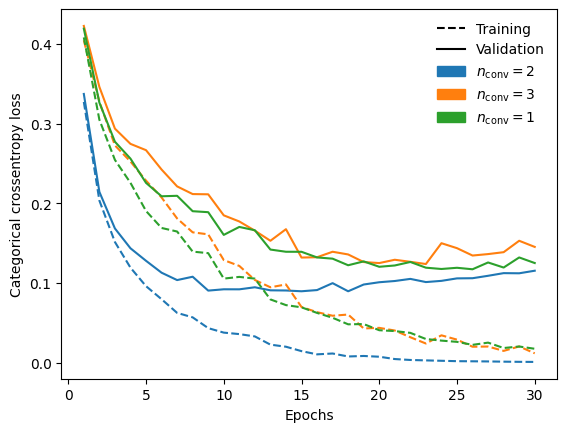

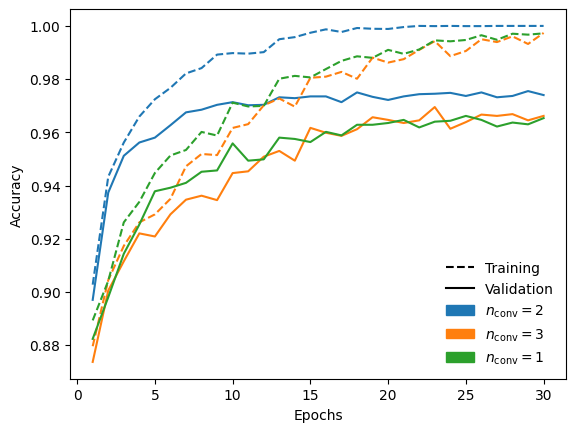

In [ ]:
# which combinations perform best?
df = pd.DataFrame(search_results).sort_values('best_val_acc', ascending=False)
display(df)

top_3_indices = df.index.values[:3]


# empty plots, just to get the legend entries
plt.plot([],[],'k--', label='Training')
plt.plot([],[],'k-', label='Validation')

# let's have a look at loss curves of the three best performing models
for idx, (row_index, row_series) in enumerate(df.head(3).iterrows()):
  x = np.arange(1, len(row_series['history']['train_loss'])+1)
  parameter_combination_string = f"$n_\\mathrm{{conv}}=${row_series['num_conv_layers']}"
  plt.plot(x, row_series['history']['train_loss'], '--', color=f'C{idx}')
  plt.plot(x, row_series['history']['val_loss'], '-', color=f'C{idx}')

  # and again empty, just for the legend entry
  plt.fill_between([],[],[],color=f'C{idx}', label=parameter_combination_string)


plt.xlabel('Epochs')
plt.ylabel('Categorical crossentropy loss')

# people should use those frames less frequently I think
plt.legend(frameon=False)
plt.show()

# empty plots, just to get the legend entries
plt.plot([],[],'k--', label='Training')
plt.plot([],[],'k-', label='Validation')

# let's have a look at loss curves of the three best performing models
for idx, (row_index, row_series) in enumerate(df.head(3).iterrows()):
  x = np.arange(1, len(row_series['history']['train_accuracy'])+1)
  parameter_combination_string = f"$n_\\mathrm{{conv}}=${row_series['num_conv_layers']}"
  plt.plot(x, row_series['history']['train_accuracy'], '--', color=f'C{idx}')
  plt.plot(x, row_series['history']['val_accuracy'], '-', color=f'C{idx}')

  # and again empty, just for the legend entry
  plt.fill_between([],[],[],color=f'C{idx}', label=parameter_combination_string)


plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# people should use those frames less frequently I think
plt.legend(frameon=False)



The best results are achieved using 2 convolutional layers, all structures seem to have high enough capacity to solve the learning problem. There is strong overtraining.

In [ ]:
# Solution for task 4

# 2. Compare different numbers of max filters:
param_space = {
    'num_conv_layers': [2],
    'max_filters': [16, 32, 64, 128],
    'dropout': [0],
    'dense_nodes': [32]
}

value_combis = itertools.product(*[v for v in param_space.values()])

# List comprehension short form:
param_combis = [{key:value for key, value in zip(param_space.keys(), combi)} for combi in value_combis]

print(f"We have a total of {len(param_combis)} combinations:")
print(param_combis)

class HistoryEpoch(Callback):
    def __init__(self, data):
        self.data = data

    def on_epoch_end(self, epoch, logs={}):
        x, y = self.data
        l, a = self.model.evaluate(x, y, verbose=0)
        logs['train_loss'] = l
        logs['train_accuracy'] = a

search_results = []

# reuse from before:
for idx, params in enumerate(param_combis):

    print(f"Start run {idx+1}/{len(param_combis)}: Parameters: {params}")

    model = Sequential()
    model.add(InputLayer(x_train[0].shape))

    filters = params['max_filters']
    for layer in range(params['num_conv_layers']):
      model.add(Conv2D(
          filters, kernel_size=2, padding='valid',
          activation='relu'
      ))
      filters /= 2

    for layer in [
      MaxPooling2D(pool_size=2),
      Dropout(params['dropout']),
      Flatten(),
      Dense(params['dense_nodes'], activation='relu'),
      Dropout(params['dropout']),
      Dense(10, activation='softmax')
    ]:
      model.add(layer)

    model.compile(
        loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']
    )
    ########################################

    # we choose our best model as the one having the highest validation accuracy
    string_config = ""
    for key, value in params.items():
      string_config += key + "=" + str(value)
    filepath = f"cnn_paramsearch_filters_{string_config}.hdf5"
    checkpoint = ModelCheckpoint(
        filepath, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max'
    )

    fit_results = model.fit(
      x=x_train,
      y=y_train,
      batch_size=128,
      # for a real scenario this must be higher!
      epochs=30,
      validation_data=(x_val, y_val),
      callbacks=[checkpoint, HistoryEpoch((x_train, y_train))],
      verbose=0
    )

    # extract the best validation scores
    best_val_epoch    = np.argmax(fit_results.history['val_accuracy'])
    best_val_acc      = np.max(fit_results.history['val_accuracy'])
    best_val_acc_loss = fit_results.history['val_loss'][best_val_epoch]

    # get correct training accuracy
    best_val_acc_train_loss = fit_results.history['train_loss'][best_val_epoch]
    best_val_acc_train_acc = fit_results.history['train_accuracy'][best_val_epoch]

    # store results
    search_results.append({
        **params,
        'best_val_acc_train_acc': best_val_acc_train_acc,
        'best_val_acc': best_val_acc,
        'best_val_acc_train_loss': best_val_acc_train_loss,
        'best_val_acc_loss': best_val_acc_loss,
        'best_val_epoch': best_val_epoch,
        'history': fit_results.history
    })

We have a total of 4 combinations:
[{'num_conv_layers': 2, 'max_filters': 16, 'dropout': 0, 'dense_nodes': 32}, {'num_conv_layers': 2, 'max_filters': 32, 'dropout': 0, 'dense_nodes': 32}, {'num_conv_layers': 2, 'max_filters': 64, 'dropout': 0, 'dense_nodes': 32}, {'num_conv_layers': 2, 'max_filters': 128, 'dropout': 0, 'dense_nodes': 32}]
Start run 1/4: Parameters: {'num_conv_layers': 2, 'max_filters': 16, 'dropout': 0, 'dense_nodes': 32}


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Start run 2/4: Parameters: {'num_conv_layers': 2, 'max_filters': 32, 'dropout': 0, 'dense_nodes': 32}
Start run 3/4: Parameters: {'num_conv_layers': 2, 'max_filters': 64, 'dropout': 0, 'dense_nodes': 32}
Start run 4/4: Parameters: {'num_conv_layers': 2, 'max_filters': 128, 'dropout': 0, 'dense_nodes': 32}


,num_conv_layers,max_filters,dropout,dense_nodes,best_val_acc_train_acc,best_val_acc,best_val_acc_train_loss,best_val_acc_loss,best_val_epoch,history
3,2,128,0,32,1.0000,0.979000,0.000428,0.107134,15,"{'loss': [0.5684728026390076, 0.20058608055114..."
1,2,32,0,32,1.0000,0.976500,0.000322,0.120384,29,"{'loss': [0.7171685099601746, 0.24530729651451..."
2,2,64,0,32,1.0000,0.976500,0.000225,0.121530,23,"{'loss': [0.6095076203346252, 0.20966188609600..."
0,2,16,0,32,0.9995,0.970833,0.005204,0.118736,26,"{'loss': [0.863456666469574, 0.318038046360015..."


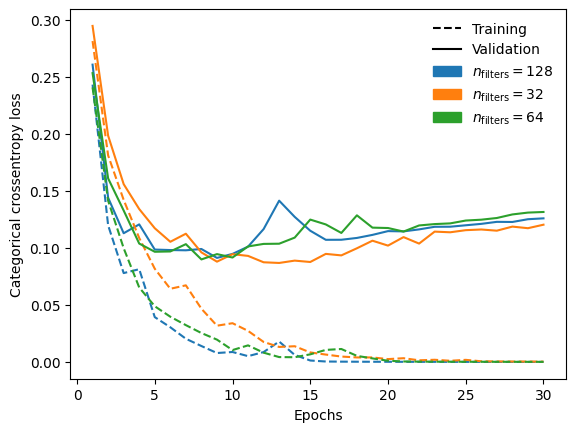

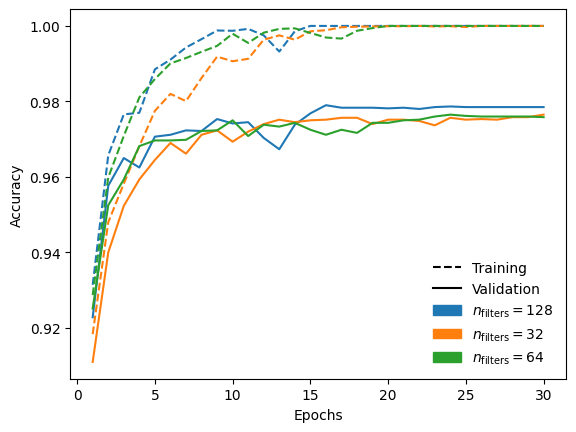

In [ ]:
# which combinations perform best?
df = pd.DataFrame(search_results).sort_values('best_val_acc', ascending=False)
display(df)

top_3_indices = df.index.values[:3]


# empty plots, just to get the legend entries
plt.plot([],[],'k--', label='Training')
plt.plot([],[],'k-', label='Validation')

# let's have a look at loss curves of the three best performing models
for idx, (row_index, row_series) in enumerate(df.head(3).iterrows()):
  x = np.arange(1, len(row_series['history']['train_loss'])+1)
  parameter_combination_string = f"$n_\\mathrm{{filters}}=${row_series['max_filters']}"
  plt.plot(x, row_series['history']['train_loss'], '--', color=f'C{idx}')
  plt.plot(x, row_series['history']['val_loss'], '-', color=f'C{idx}')

  # and again empty, just for the legend entry
  plt.fill_between([],[],[],color=f'C{idx}', label=parameter_combination_string)


plt.xlabel('Epochs')
plt.ylabel('Categorical crossentropy loss')

# people should use those frames less frequently I think
plt.legend(frameon=False)
plt.show()

# empty plots, just to get the legend entries
plt.plot([],[],'k--', label='Training')
plt.plot([],[],'k-', label='Validation')

# let's have a look at loss curves of the three best performing models
for idx, (row_index, row_series) in enumerate(df.head(3).iterrows()):
  x = np.arange(1, len(row_series['history']['train_accuracy'])+1)
  parameter_combination_string = f"$n_\\mathrm{{filters}}=${row_series['max_filters']}"
  plt.plot(x, row_series['history']['train_accuracy'], '--', color=f'C{idx}')
  plt.plot(x, row_series['history']['val_accuracy'], '-', color=f'C{idx}')

  # and again empty, just for the legend entry
  plt.fill_between([],[],[],color=f'C{idx}', label=parameter_combination_string)


plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# people should use those frames less frequently I think
plt.legend(frameon=False)



The best accuracy was found for 32 filters which is also the smallest model. Therefore, we choose it.

In [ ]:
# Solution for task 4

# 3. Find the best dense structure:
param_space = {
    'num_conv_layers': [2],
    'max_filters': [32],
    'dropout': [0],
    'dense_nodes': [[16], [32], [32, 16], [64, 32]]
}

value_combis = itertools.product(*[v for v in param_space.values()])

# List comprehension short form:
param_combis = [{key:value for key, value in zip(param_space.keys(), combi)} for combi in value_combis]

print(f"We have a total of {len(param_combis)} combinations:")
print(param_combis)

class HistoryEpoch(Callback):
    def __init__(self, data):
        self.data = data

    def on_epoch_end(self, epoch, logs={}):
        x, y = self.data
        l, a = self.model.evaluate(x, y, verbose=0)
        logs['train_loss'] = l
        logs['train_accuracy'] = a

search_results = []

# reuse from before:
for idx, params in enumerate(param_combis):

    print(f"Start run {idx+1}/{len(param_combis)}: Parameters: {params}")

    model = Sequential()
    model.add(InputLayer(x_train[0].shape))

    filters = params['max_filters']
    for layer in range(params['num_conv_layers']):
      model.add(Conv2D(
          filters, kernel_size=2, padding='valid',
          activation='relu'
      ))
      filters /= 2

    for layer in [
      MaxPooling2D(pool_size=2),
      Dropout(params['dropout']),
      Flatten(),
    ]:
      model.add(layer)
    for nodes in params['dense_nodes']:
      model.add(Dense(nodes, activation='relu'))
      model.add(Dropout(params['dropout']))

    model.add(Dense(10, activation='softmax'))

    model.compile(
        loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']
    )
    ########################################

    # we choose our best model as the one having the highest validation accuracy
    string_config = ""
    for key, value in params.items():
      string_config += key + "=" + str(value)
    filepath = f"cnn_paramsearch_filters_{string_config}.hdf5"
    checkpoint = ModelCheckpoint(
        filepath, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max'
    )

    fit_results = model.fit(
      x=x_train,
      y=y_train,
      batch_size=128,
      # for a real scenario this must be higher!
      epochs=30,
      validation_data=(x_val, y_val),
      callbacks=[checkpoint, HistoryEpoch((x_train, y_train))],
      verbose=0
    )

    # extract the best validation scores
    best_val_epoch    = np.argmax(fit_results.history['val_accuracy'])
    best_val_acc      = np.max(fit_results.history['val_accuracy'])
    best_val_acc_loss = fit_results.history['val_loss'][best_val_epoch]

    # get correct training accuracy
    best_val_acc_train_loss = fit_results.history['train_loss'][best_val_epoch]
    best_val_acc_train_acc = fit_results.history['train_accuracy'][best_val_epoch]

    # store results
    search_results.append({
        **params,
        'best_val_acc_train_acc': best_val_acc_train_acc,
        'best_val_acc': best_val_acc,
        'best_val_acc_train_loss': best_val_acc_train_loss,
        'best_val_acc_loss': best_val_acc_loss,
        'best_val_epoch': best_val_epoch,
        'history': fit_results.history
    })

We have a total of 4 combinations:
[{'num_conv_layers': 2, 'max_filters': 32, 'dropout': 0, 'dense_nodes': [16]}, {'num_conv_layers': 2, 'max_filters': 32, 'dropout': 0, 'dense_nodes': [32]}, {'num_conv_layers': 2, 'max_filters': 32, 'dropout': 0, 'dense_nodes': [32, 16]}, {'num_conv_layers': 2, 'max_filters': 32, 'dropout': 0, 'dense_nodes': [64, 32]}]
Start run 1/4: Parameters: {'num_conv_layers': 2, 'max_filters': 32, 'dropout': 0, 'dense_nodes': [16]}
Start run 2/4: Parameters: {'num_conv_layers': 2, 'max_filters': 32, 'dropout': 0, 'dense_nodes': [32]}
Start run 3/4: Parameters: {'num_conv_layers': 2, 'max_filters': 32, 'dropout': 0, 'dense_nodes': [32, 16]}
Start run 4/4: Parameters: {'num_conv_layers': 2, 'max_filters': 32, 'dropout': 0, 'dense_nodes': [64, 32]}


,num_conv_layers,max_filters,dropout,dense_nodes,best_val_acc_train_acc,best_val_acc,best_val_acc_train_loss,best_val_acc_loss,best_val_epoch,history
3,2,32,0,"[64, 32]",1.0,0.979833,0.000124,0.108407,26,"{'loss': [0.7063049077987671, 0.23186218738555..."
1,2,32,0,[32],1.0,0.975667,0.000695,0.114815,28,"{'loss': [0.7929758429527283, 0.30196255445480..."
0,2,32,0,[16],1.0,0.972833,0.001106,0.143508,28,"{'loss': [0.8111981749534607, 0.30926656723022..."
2,2,32,0,"[32, 16]",1.0,0.972333,0.000315,0.159349,28,"{'loss': [0.9688035249710083, 0.29164227843284..."


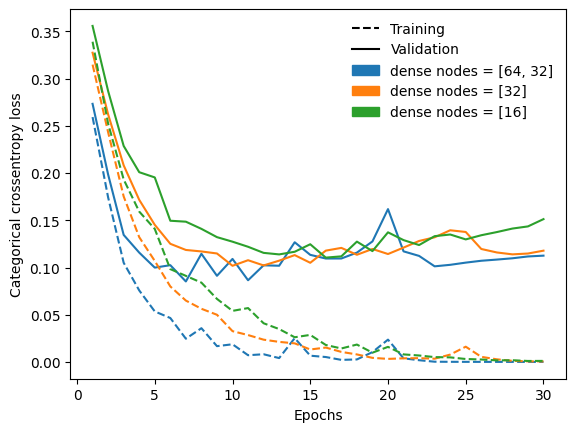

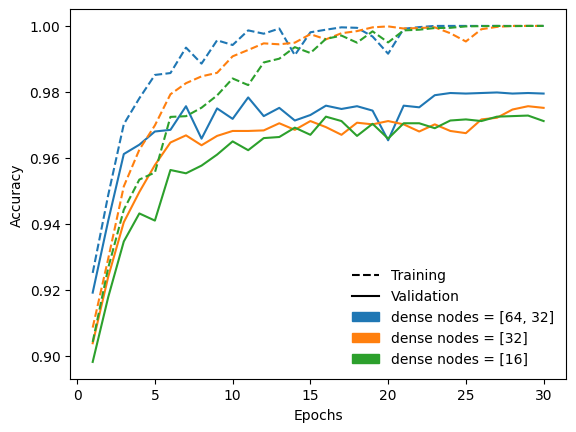

In [ ]:
# which combinations perform best?
df = pd.DataFrame(search_results).sort_values('best_val_acc', ascending=False)
display(df)

top_3_indices = df.index.values[:3]


# empty plots, just to get the legend entries
plt.plot([],[],'k--', label='Training')
plt.plot([],[],'k-', label='Validation')

# let's have a look at loss curves of the three best performing models
for idx, (row_index, row_series) in enumerate(df.head(3).iterrows()):
  x = np.arange(1, len(row_series['history']['train_loss'])+1)
  parameter_combination_string = f"dense nodes = {row_series['dense_nodes']}"
  plt.plot(x, row_series['history']['train_loss'], '--', color=f'C{idx}')
  plt.plot(x, row_series['history']['val_loss'], '-', color=f'C{idx}')

  # and again empty, just for the legend entry
  plt.fill_between([],[],[],color=f'C{idx}', label=parameter_combination_string)


plt.xlabel('Epochs')
plt.ylabel('Categorical crossentropy loss')

# people should use those frames less frequently I think
plt.legend(frameon=False)
plt.show()

# empty plots, just to get the legend entries
plt.plot([],[],'k--', label='Training')
plt.plot([],[],'k-', label='Validation')

# let's have a look at loss curves of the three best performing models
for idx, (row_index, row_series) in enumerate(df.head(3).iterrows()):
  x = np.arange(1, len(row_series['history']['train_accuracy'])+1)
  parameter_combination_string = f"dense nodes = {row_series['dense_nodes']}"
  plt.plot(x, row_series['history']['train_accuracy'], '--', color=f'C{idx}')
  plt.plot(x, row_series['history']['val_accuracy'], '-', color=f'C{idx}')

  # and again empty, just for the legend entry
  plt.fill_between([],[],[],color=f'C{idx}', label=parameter_combination_string)


plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# people should use those frames less frequently I think
plt.legend(frameon=False)



The second dense layer seems not to give advantages. Therefore we choose one layer with 32 nodes. We can continue like this for other variables or do two dimensional searches.

In [ ]:
# Solution for task 4

# 4. Try to regularize with dropout
param_space = {
    'num_conv_layers': [2],
    'max_filters': [32],
    'dense_nodes': [[32]],
    'dropout': [0, .15, .3, .4, .5]
}

value_combis = itertools.product(*[v for v in param_space.values()])

# List comprehension short form:
param_combis = [{key:value for key, value in zip(param_space.keys(), combi)} for combi in value_combis]

print(f"We have a total of {len(param_combis)} combinations:")
print(param_combis)

class HistoryEpoch(Callback):
    def __init__(self, data):
        self.data = data

    def on_epoch_end(self, epoch, logs={}):
        x, y = self.data
        l, a = self.model.evaluate(x, y, verbose=0)
        logs['train_loss'] = l
        logs['train_accuracy'] = a

search_results = []

# reuse from before:
for idx, params in enumerate(param_combis):

    print(f"Start run {idx+1}/{len(param_combis)}: Parameters: {params}")

    model = Sequential()
    model.add(InputLayer(x_train[0].shape))

    filters = params['max_filters']
    for layer in range(params['num_conv_layers']):
      model.add(Conv2D(
          filters, kernel_size=2, padding='valid',
          activation='relu'
      ))
      filters /= 2

    for layer in [
      MaxPooling2D(pool_size=2),
      Dropout(params['dropout']),
      Flatten(),
      Dropout(params['dropout'])
    ]:
      model.add(layer)
    for nodes in params['dense_nodes']:
      model.add(Dense(nodes, activation='relu'))
      model.add(Dropout(params['dropout']))

    model.add(Dense(10, activation='softmax'))

    model.compile(
        loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']
    )
    ########################################

    # we choose our best model as the one having the highest validation accuracy
    string_config = ""
    for key, value in params.items():
      string_config += key + "=" + str(value)
    filepath = f"cnn_paramsearch_filters_{string_config}.hdf5"
    checkpoint = ModelCheckpoint(
        filepath, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max'
    )

    fit_results = model.fit(
      x=x_train,
      y=y_train,
      batch_size=128,
      # for a real scenario this must be higher!
      epochs=30,
      validation_data=(x_val, y_val),
      callbacks=[checkpoint, HistoryEpoch((x_train, y_train))],
      verbose=0
    )

    # extract the best validation scores
    best_val_epoch    = np.argmax(fit_results.history['val_accuracy'])
    best_val_acc      = np.max(fit_results.history['val_accuracy'])
    best_val_acc_loss = fit_results.history['val_loss'][best_val_epoch]

    # get correct training accuracy
    best_val_acc_train_loss = fit_results.history['train_loss'][best_val_epoch]
    best_val_acc_train_acc = fit_results.history['train_accuracy'][best_val_epoch]

    # store results
    search_results.append({
        **params,
        'best_val_acc_train_acc': best_val_acc_train_acc,
        'best_val_acc': best_val_acc,
        'best_val_acc_train_loss': best_val_acc_train_loss,
        'best_val_acc_loss': best_val_acc_loss,
        'best_val_epoch': best_val_epoch,
        'history': fit_results.history
    })

We have a total of 5 combinations:
[{'num_conv_layers': 2, 'max_filters': 32, 'dense_nodes': [32], 'dropout': 0}, {'num_conv_layers': 2, 'max_filters': 32, 'dense_nodes': [32], 'dropout': 0.15}, {'num_conv_layers': 2, 'max_filters': 32, 'dense_nodes': [32], 'dropout': 0.3}, {'num_conv_layers': 2, 'max_filters': 32, 'dense_nodes': [32], 'dropout': 0.4}, {'num_conv_layers': 2, 'max_filters': 32, 'dense_nodes': [32], 'dropout': 0.5}]
Start run 1/5: Parameters: {'num_conv_layers': 2, 'max_filters': 32, 'dense_nodes': [32], 'dropout': 0}
Start run 2/5: Parameters: {'num_conv_layers': 2, 'max_filters': 32, 'dense_nodes': [32], 'dropout': 0.15}
Start run 3/5: Parameters: {'num_conv_layers': 2, 'max_filters': 32, 'dense_nodes': [32], 'dropout': 0.3}
Start run 4/5: Parameters: {'num_conv_layers': 2, 'max_filters': 32, 'dense_nodes': [32], 'dropout': 0.4}
Start run 5/5: Parameters: {'num_conv_layers': 2, 'max_filters': 32, 'dense_nodes': [32], 'dropout': 0.5}


,num_conv_layers,max_filters,dense_nodes,dropout,best_val_acc_train_acc,best_val_acc,best_val_acc_train_loss,best_val_acc_loss,best_val_epoch,history
1,2,32,[32],0.15,0.999429,0.981167,0.005056,0.070840,27,"{'loss': [0.8768553733825684, 0.36905103921890..."
2,2,32,[32],0.30,0.991571,0.979167,0.028959,0.076399,24,"{'loss': [1.0953327417373657, 0.50008267164230..."
3,2,32,[32],0.40,0.986929,0.979000,0.045301,0.078657,28,"{'loss': [1.303389072418213, 0.691337585449218..."
0,2,32,[32],0.00,0.999786,0.975333,0.003082,0.110877,16,"{'loss': [0.7472898960113525, 0.25718510150909..."
4,2,32,[32],0.50,0.979000,0.973000,0.078539,0.101517,29,"{'loss': [1.5576748847961426, 0.86505591869354..."


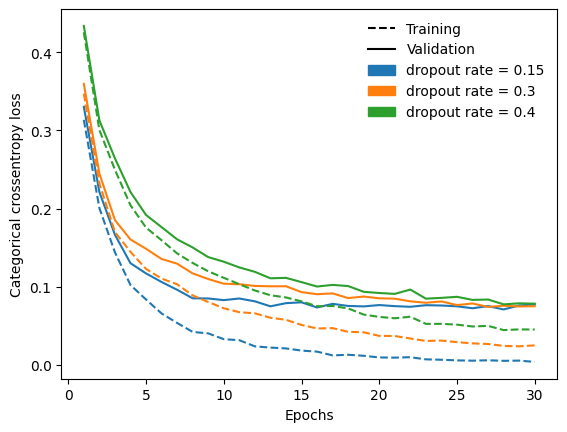

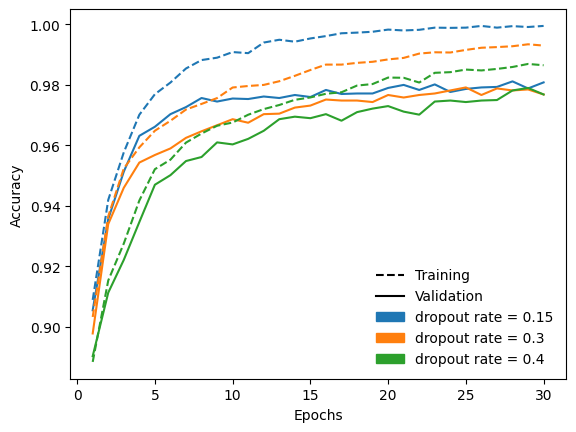

In [ ]:
# which combinations perform best?
df = pd.DataFrame(search_results).sort_values('best_val_acc', ascending=False)
display(df)

top_3_indices = df.index.values[:3]


# empty plots, just to get the legend entries
plt.plot([],[],'k--', label='Training')
plt.plot([],[],'k-', label='Validation')

# let's have a look at loss curves of the three best performing models
for idx, (row_index, row_series) in enumerate(df.head(3).iterrows()):
  x = np.arange(1, len(row_series['history']['train_loss'])+1)
  parameter_combination_string = f"dropout rate = {row_series['dropout']}"
  plt.plot(x, row_series['history']['train_loss'], '--', color=f'C{idx}')
  plt.plot(x, row_series['history']['val_loss'], '-', color=f'C{idx}')

  # and again empty, just for the legend entry
  plt.fill_between([],[],[],color=f'C{idx}', label=parameter_combination_string)


plt.xlabel('Epochs')
plt.ylabel('Categorical crossentropy loss')

# people should use those frames less frequently I think
plt.legend(frameon=False)
plt.show()

# empty plots, just to get the legend entries
plt.plot([],[],'k--', label='Training')
plt.plot([],[],'k-', label='Validation')

# let's have a look at loss curves of the three best performing models
for idx, (row_index, row_series) in enumerate(df.head(3).iterrows()):
  x = np.arange(1, len(row_series['history']['train_accuracy'])+1)
  parameter_combination_string = f"dropout rate = {row_series['dropout']}"
  plt.plot(x, row_series['history']['train_accuracy'], '--', color=f'C{idx}')
  plt.plot(x, row_series['history']['val_accuracy'], '-', color=f'C{idx}')

  # and again empty, just for the legend entry
  plt.fill_between([],[],[],color=f'C{idx}', label=parameter_combination_string)


plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# people should use those frames less frequently I think
plt.legend(frameon=False)



In [ ]:
# Solution for task 4

# 5. Dropout did not show optimal results, so we will add on top l2 regularization
param_space = {
    'num_conv_layers': [2],
    'max_filters': [32],
    'dense_nodes': [[32]],
    'dropout': [.3],
    'l2': [1e-6, 1e-5, 1e-4, 1e-3]
}

from tensorflow.keras.regularizers import l2

value_combis = itertools.product(*[v for v in param_space.values()])

# List comprehension short form:
param_combis = [{key:value for key, value in zip(param_space.keys(), combi)} for combi in value_combis]

print(f"We have a total of {len(param_combis)} combinations:")
print(param_combis)

class HistoryEpoch(Callback):
    def __init__(self, data):
        self.data = data

    def on_epoch_end(self, epoch, logs={}):
        x, y = self.data
        l, a = self.model.evaluate(x, y, verbose=0)
        logs['train_loss'] = l
        logs['train_accuracy'] = a

search_results = []

# reuse from before:
for idx, params in enumerate(param_combis):

    print(f"Start run {idx+1}/{len(param_combis)}: Parameters: {params}")

    model = Sequential()
    model.add(InputLayer(x_train[0].shape))

    filters = params['max_filters']
    for layer in range(params['num_conv_layers']):
      model.add(Conv2D(
          filters, kernel_size=2, padding='valid',
          activation='relu', kernel_regularizer=l2(params['l2'])
      ))
      filters /= 2

    for layer in [
      MaxPooling2D(pool_size=2),
      Flatten(),
      Dropout(params['dropout'])
    ]:
      model.add(layer)
    for nodes in params['dense_nodes']:
      model.add(Dense(nodes, activation='relu', kernel_regularizer=l2(params['l2'])))
      model.add(Dropout(params['dropout']))

    model.add(Dense(10, activation='softmax'))

    model.compile(
        loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']
    )
    ########################################

    # we choose our best model as the one having the highest validation accuracy
    string_config = ""
    for key, value in params.items():
      string_config += key + "=" + str(value)
    filepath = f"cnn_paramsearch_filters_{string_config}.hdf5"
    checkpoint = ModelCheckpoint(
        filepath, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max'
    )

    fit_results = model.fit(
      x=x_train,
      y=y_train,
      batch_size=128,
      # for a real scenario this must be higher!
      epochs=30,
      validation_data=(x_val, y_val),
      callbacks=[checkpoint, HistoryEpoch((x_train, y_train))],
      verbose=0
    )

    # extract the best validation scores
    best_val_epoch    = np.argmax(fit_results.history['val_accuracy'])
    best_val_acc      = np.max(fit_results.history['val_accuracy'])
    best_val_acc_loss = fit_results.history['val_loss'][best_val_epoch]

    # get correct training accuracy
    best_val_acc_train_loss = fit_results.history['train_loss'][best_val_epoch]
    best_val_acc_train_acc = fit_results.history['train_accuracy'][best_val_epoch]

    # store results
    search_results.append({
        **params,
        'best_val_acc_train_acc': best_val_acc_train_acc,
        'best_val_acc': best_val_acc,
        'best_val_acc_train_loss': best_val_acc_train_loss,
        'best_val_acc_loss': best_val_acc_loss,
        'best_val_epoch': best_val_epoch,
        'history': fit_results.history
    })

We have a total of 4 combinations:
[{'num_conv_layers': 2, 'max_filters': 32, 'dense_nodes': [32], 'dropout': 0.3, 'l2': 1e-06}, {'num_conv_layers': 2, 'max_filters': 32, 'dense_nodes': [32], 'dropout': 0.3, 'l2': 1e-05}, {'num_conv_layers': 2, 'max_filters': 32, 'dense_nodes': [32], 'dropout': 0.3, 'l2': 0.0001}, {'num_conv_layers': 2, 'max_filters': 32, 'dense_nodes': [32], 'dropout': 0.3, 'l2': 0.001}]
Start run 1/4: Parameters: {'num_conv_layers': 2, 'max_filters': 32, 'dense_nodes': [32], 'dropout': 0.3, 'l2': 1e-06}
Start run 2/4: Parameters: {'num_conv_layers': 2, 'max_filters': 32, 'dense_nodes': [32], 'dropout': 0.3, 'l2': 1e-05}
Start run 3/4: Parameters: {'num_conv_layers': 2, 'max_filters': 32, 'dense_nodes': [32], 'dropout': 0.3, 'l2': 0.0001}
Start run 4/4: Parameters: {'num_conv_layers': 2, 'max_filters': 32, 'dense_nodes': [32], 'dropout': 0.3, 'l2': 0.001}


,num_conv_layers,max_filters,dense_nodes,dropout,l2,best_val_acc_train_acc,best_val_acc,best_val_acc_train_loss,best_val_acc_loss,best_val_epoch,history
1,2,32,[32],0.3,0.000010,0.997786,0.982000,0.014309,0.071825,28,"{'loss': [1.0562489032745361, 0.44790175557136..."
0,2,32,[32],0.3,0.000001,0.995786,0.981833,0.017204,0.067972,20,"{'loss': [1.0120865106582642, 0.45621693134307..."
2,2,32,[32],0.3,0.000100,0.996786,0.981500,0.041278,0.098835,29,"{'loss': [1.024312973022461, 0.503875434398651..."
3,2,32,[32],0.3,0.001000,0.991071,0.980167,0.126646,0.165728,26,"{'loss': [1.048958659172058, 0.589553415775299..."


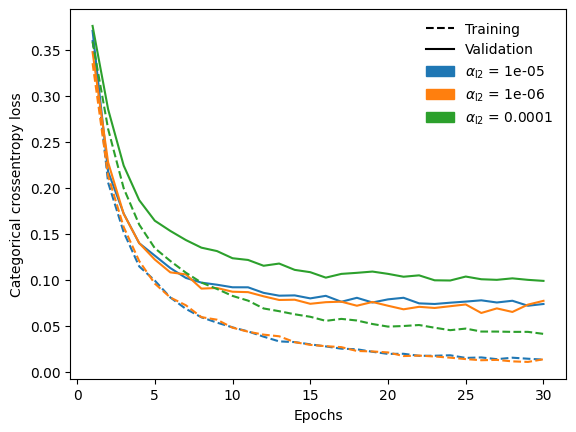

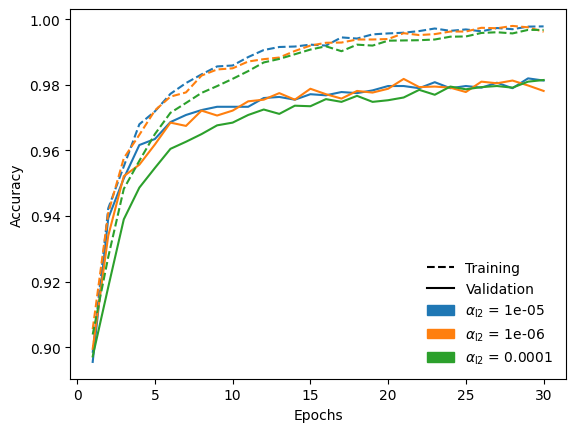

In [ ]:
# which combinations perform best?
df = pd.DataFrame(search_results).sort_values('best_val_acc', ascending=False)
display(df)

top_3_indices = df.index.values[:3]


# empty plots, just to get the legend entries
plt.plot([],[],'k--', label='Training')
plt.plot([],[],'k-', label='Validation')

# let's have a look at loss curves of the three best performing models
for idx, (row_index, row_series) in enumerate(df.head(3).iterrows()):
  x = np.arange(1, len(row_series['history']['train_loss'])+1)
  parameter_combination_string = f"$\\alpha_\\mathrm{{l2}}$ = {row_series['l2']}"
  plt.plot(x, row_series['history']['train_loss'], '--', color=f'C{idx}')
  plt.plot(x, row_series['history']['val_loss'], '-', color=f'C{idx}')

  # and again empty, just for the legend entry
  plt.fill_between([],[],[],color=f'C{idx}', label=parameter_combination_string)


plt.xlabel('Epochs')
plt.ylabel('Categorical crossentropy loss')

# people should use those frames less frequently I think
plt.legend(frameon=False)
plt.show()

# empty plots, just to get the legend entries
plt.plot([],[],'k--', label='Training')
plt.plot([],[],'k-', label='Validation')

# let's have a look at loss curves of the three best performing models
for idx, (row_index, row_series) in enumerate(df.head(3).iterrows()):
  x = np.arange(1, len(row_series['history']['train_accuracy'])+1)
  parameter_combination_string = f"$\\alpha_\\mathrm{{l2}}$ = {row_series['l2']}"
  plt.plot(x, row_series['history']['train_accuracy'], '--', color=f'C{idx}')
  plt.plot(x, row_series['history']['val_accuracy'], '-', color=f'C{idx}')

  # and again empty, just for the legend entry
  plt.fill_between([],[],[],color=f'C{idx}', label=parameter_combination_string)


plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# people should use those frames less frequently I think
plt.legend(frameon=False)



The overall best results were achieved using
- 2 convolutional layers
- 32 filters in the first layer, 16 in the second
- one dense layer with 32 nodes
- dropout of 30%
- l2 regularization with a factor of 1e-6

## Tips for Hyperparameter Optimization
This section lists some handy tips to consider when tuning hyperparameters of your neural network.

* **k-fold Cross Validation.** You can see that the results from the examples in this post show some variance. For speed reasons, we used a cross-validation of 2, but perhaps k=5 or k=10 would be more stable. Carefully choose your cross validation configuration to ensure your results are stable.
* **Review the Whole Grid.** Do not just focus on the best result, review the whole grid of results and look for trends to support configuration decisions.
* **Parallelize.** Use all your cores if you can, neural networks are slow to train and we often want to try a lot of different parameters. Consider using cluster instances if available.
* **Use a Subsample of Your Dataset.** Because networks are slow to train, try training them on a smaller sample of your training dataset, just to get an idea of general directions of parameters rather than optimal configurations.
* **Start with Coarse Grids.** Start with coarse-grained grids and zoom into finer grained grids once you can narrow the scope.
* **Do not Transfer Results.** Results are generally problem specific. Try to avoid favorite configurations on each new problem that you see. It is unlikely that optimal results you discover on one problem will transfer to your next project. Instead look for broader trends like number of layers or relationships between parameters.
* **Reproducibility is a Problem.** Although we set the seed for the random number generator in NumPy, the results are not 100% reproducible.

## Task 5: Load the best model and evaluate it using the function below
You can load the model using<br>
`from tensorflow.keras.models import load_model`<br>
`model= load_model('filename')`

In [ ]:
###################################################################################################

import matplotlib.pyplot as plt
%matplotlib inline

def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(network_history.history['acc'])
    plt.plot(network_history.history['val_acc'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

###################################################################################################

import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

###################################################################################################
import matplotlib.cm as cm
def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)), cmap=cm.Greys, interpolation='nearest')
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

###################################################################################################
from sklearn.metrics import confusion_matrix,classification_report

def evaluate(X_train, Y_train, X_test, Y_test, model):

    ##Evaluate loss and metrics
    loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
    print('Test Loss:', loss)
    print('Test Accuracy:', accuracy)
    # Predict the values from the test dataset
    Y_pred = model.predict(X_test)
    # Convert predictions classes to one hot vectors
    Y_cls = np.argmax(Y_pred, axis = 1)
    # Convert validation observations to one hot vectors
    Y_true = np.argmax(Y_test, axis = 1)
    print('Classification Report:\n', classification_report(Y_true,Y_cls))

    ## Plot 0 probability including overtraining test
    plt.figure(figsize=(8,8))

    label=0
    #Test prediction
    Y_pred_prob = Y_pred[:,label]
    plt.hist(Y_pred_prob[Y_true == label], alpha=0.5, color='red', range=[0, 1], bins=10, log = True)
    plt.hist(Y_pred_prob[Y_true != label], alpha=0.5, color='blue', range=[0, 1], bins=10, log = True)
    #Train prediction
    Y_train_pred = model.predict(X_train)
    Y_train_pred_prob = Y_train_pred[:,label]
    Y_train_true = np.argmax(Y_train, axis = 1)
    plt.hist(Y_train_pred_prob[Y_train_true == label], alpha=0.5, color='red', range=[0, 1], bins=10, log = True, histtype='step', linewidth=2)
    plt.hist(Y_train_pred_prob[Y_train_true != label], alpha=0.5, color='blue', range=[0, 1], bins=10, log = True, histtype='step', linewidth=2)

    plt.legend(['train == 0', 'train != 0', 'test == 0', 'test != 0'], loc='upper right')
    plt.xlabel('Probability of being 0')
    plt.ylabel('Number of entries')
    plt.show()

    # compute the confusion matrix
    confusion_mtx = confusion_matrix(Y_true, Y_cls)
    # plot the confusion matrix
    plt.figure(figsize=(8,8))
    plot_confusion_matrix(confusion_mtx, classes = range(10))

    #Plot largest errors
    errors = (Y_cls - Y_true != 0)
    Y_cls_errors = Y_cls[errors]
    Y_pred_errors = Y_pred[errors]
    Y_true_errors = Y_true[errors]
    X_test_errors = X_test[errors]
    # Probabilities of the wrong predicted numbers
    Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)
    # Predicted probabilities of the true values in the error set
    true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))
    # Difference between the probability of the predicted label and the true label
    delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors
    # Sorted list of the delta prob errors
    sorted_dela_errors = np.argsort(delta_pred_true_errors)
    # Top 6 errors
    most_important_errors = sorted_dela_errors[-6:]
    # Show the top 6 errors
    display_errors(most_important_errors, X_test_errors, Y_cls_errors, Y_true_errors)

    ##Plot predictions
    slice = 15
    predicted = model.predict(X_test[:slice]).argmax(-1)
    plt.figure(figsize=(16,8))
    for i in range(slice):
        plt.subplot(1, slice, i+1)
        plt.imshow(X_test[i].reshape(28,28), interpolation='nearest')
        plt.text(0, 0, predicted[i], color='black',
                 bbox=dict(facecolor='white', alpha=1))
        plt.axis('off')

In [ ]:
# space for solutions

from tensorflow.keras.models import load_model
model= load_model('cnn_paramsearch_filters_num_conv_layers=2max_filters=32dense_nodes=[32]dropout=0.3l2=1e-06.hdf5')

Test Loss: 0.07739205658435822
Test Accuracy: 0.9776999950408936
313/313 [==============================] - 1s 2ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.98      0.98      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.97      0.98      0.98       892
           6       0.98      0.97      0.98       958
           7       0.97      0.97      0.97      1028
           8       0.98      0.97      0.97       974
           9       0.98      0.96      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000

625/625 [==============================] - 1s 2ms/step


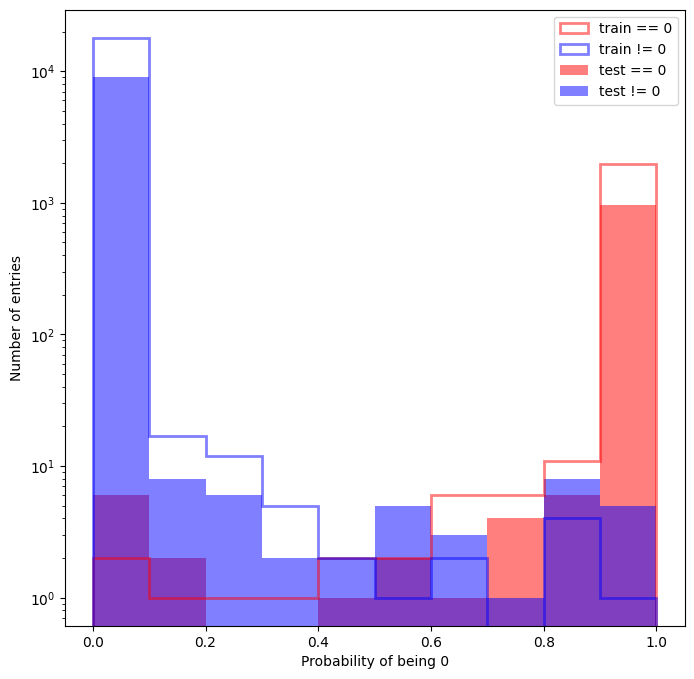

1/1 [==============================] - 0s 65ms/step


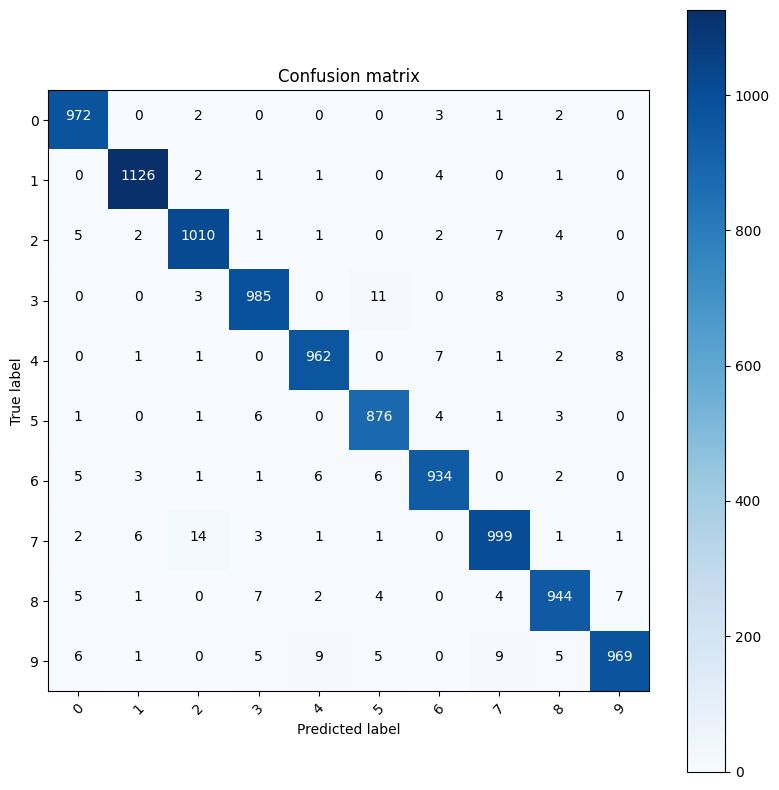

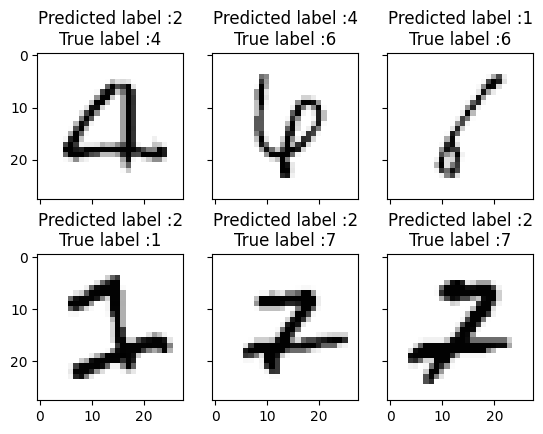

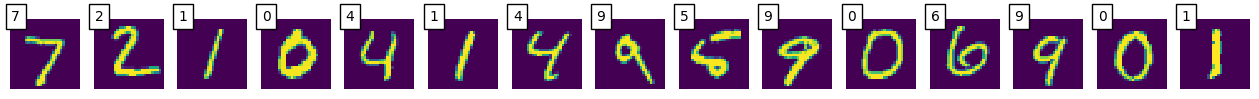

In [ ]:
evaluate(X_train_ready, Y_train_ready, X_test_ready, Y_test_ready, model)

---

## There's more:

We have had a first deep dive into cross validations and it has been quite a ride. We hope you enjoyed it though and are looking forward for more.

Searching for the best hyperparameter combination is pretty much the holy grail of modern machine learning, especially deep learning. Therefore, a lot of programs and packages have been developed for smart ways to search in very high dimensional and even conditional (search this bit if this parameter is chosen, else search another bit).

Somewhat famous packages are [spearmint](https://github.com/HIPS/Spearmint) and [hyperopt](https://github.com/hyperopt/hyperopt), which was also wrapped for keras:

* `Keras + hyperopt == hyperas`: [http://maxpumperla.github.io/hyperas/](http://maxpumperla.github.io/hyperas/)